In [1]:
import os
import glob
import math

import torch
from torch.utils.data import Dataset,DataLoader
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio

from skimage.morphology import binary_dilation
import cv2


In [2]:
#THE BANDS are BGR-NIR
#THe Bands are [B01,B02,B03,B04]
class ExploreSet(Dataset):

    def __init__(
        self,
        root = '/home/hasann/Desktop/geogroup/competition_datasets/nasa_rwanda_field_boundary_competition',
        ):

        self.root = root
        
        data = []

        for split in ['train','test']:
            img_dir = f'{root}/{split}_imgs'
            iids = [os.path.basename(f).split('_2021')[0] for f in glob.glob(f'{img_dir}/nasa_rwanda_field_boundary_competition_source*')]
            iids = list(set(iids))
            N = len(iids)
            data.extend(list(zip(iids,[split]*N)))
        
        self.months = ['03','04','08','10','11','12']
        self.year = '2021'
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    @staticmethod
    def load_channels(path):
        img = []
        for band in ['B01','B02','B03','B04']:
            img.append(rio.open(f'{path}/{band}.tif').read())
        
        img = np.vstack(img)
        return img


    
    def __getitem__(self, index,totensor = True,only_imgs=True):

        iid ,split = self.data[index]
        train_img = split == 'train'

        imgs = [] 
        for month in self.months:
            img = self.load_channels(f'{self.root}/{split}_imgs/{iid}_{self.year}_{month}')
            #print
            imgs.append(img)
        
        if train_img:
            mask_iid = iid.replace('source','labels')
            mask = rio.open(f'{self.root}/train_labels/{mask_iid}/raster_labels.tif').read()
            
        else:
            mask = None
        
        if totensor:

            imgs = np.stack(imgs,axis=0)
            #print(imgs.dtype)
            imgs = imgs.astype(np.float32)
            imgs = torch.from_numpy(imgs).float()
            if train_img:
                mask = torch.from_numpy(mask).long()
        if only_imgs:
            return imgs
        return imgs,mask
        
        

In [3]:
def normalize(img,mean,std,max_pixel_value):

    img /= max_pixel_value
    img -= mean
    img /= std

    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([6, 4, 256, 256])
[-0.26492542 -0.39259267 -0.5424999  -0.53682184]
[3.0186565 3.4444444 2.18      2.2122092]
[-0.2835821 -1.1444445 -0.445     -1.992248 ]
[5.619403  5.6629624 4.1899996 3.014535 ]
[-0.3208955  -0.50740755 -0.7925     -0.8662791 ]
[4.660448  4.2703705 4.4425    1.854651 ]
[-0.14179099 -0.45555556 -0.39750004 -1.0542636 ]
[5.9664183 6.644444  5.0025    2.864341 ]
[-0.16791052 -0.18888885 -0.22499996 -0.499031  ]
[8.5       7.1000004 5.0074997 2.4195738]
[-0.119403   -0.5296297  -0.21249998 -1.4641473 ]
[8.873135  9.240741  7.0750003 2.971899 ]


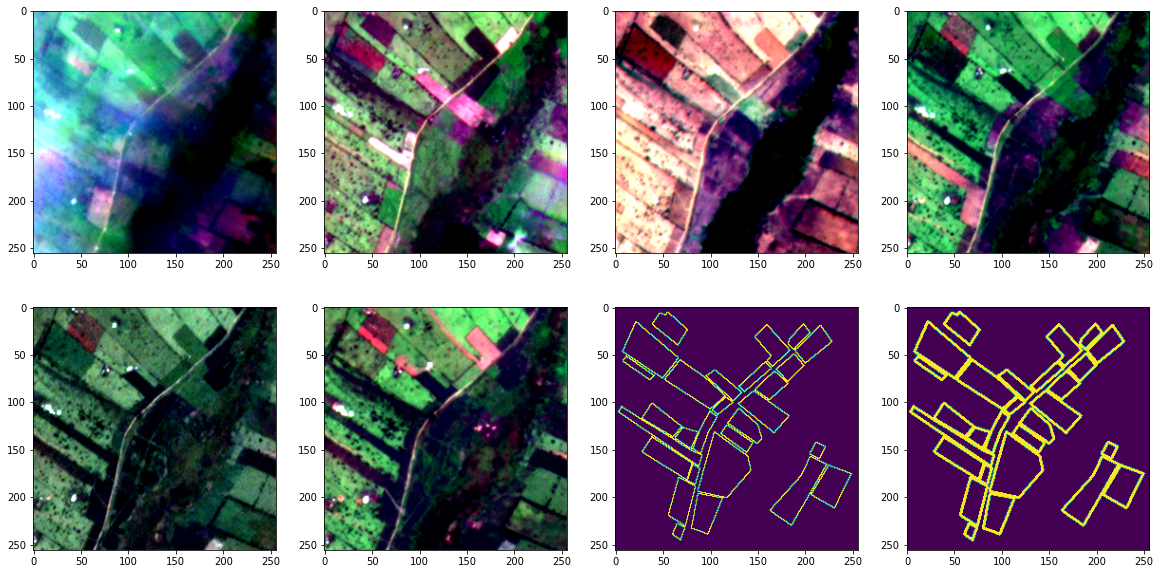

In [7]:
dataset = ExploreSet()

Mean = np.array([0.049, 0.083, 0.088, 0.303])
Std = np.array([0.0134, 0.0135, 0.02, 0.0516])
NORM = 10000 #65535


IDX = 11
imgs,mask = dataset.__getitem__(IDX,totensor=True,only_imgs=False)

print(imgs.shape)
fig,axs = plt.subplots(2,4,figsize = (20,10))

B,C,H,W = imgs.shape
for i in range(B):
    img = imgs[i,...].cpu().numpy()
    #print(img.min(axis=(1,2))/NORM)
    #print(img.max(axis=(1,2))/NORM)
    
    img = img.transpose(1,2,0)
    img = normalize(img,Mean,Std,NORM)
    
    row,col = i // 4, i%4
    
    #print(img.min(axis=(0,1)))
    #print(img.max(axis=(0,1)))

    img = img 
    img = (img + 1)/ 2

    print(img.min(axis=(0,1)))
    print(img.max(axis=(0,1)))
    rgb = img[:,:,[2,1,0]]
    axs[row,col].imshow(rgb)

mask = mask.cpu().numpy()[0]
axs[1,2].imshow(mask)
axs[1,3].imshow(binary_dilation(mask))

In [8]:
def get_index(name,r,g,b,nir):
    eps = 1
    if name == 'ndvi':
        return (nir - r)/(nir+r)
    
    elif name == 'gli':
        return (2 * g - r - b) / (2 * g + r + b)
    
    elif name == 'cvi':
        return (nir / g) * (r / g)
    
    elif name == 'sipi':
        return (nir - b) / (nir - r)
    
    elif name == 'evi':
        return 2.5 * (nir - r) / (nir + 6 * r - 7.5 * b + 1)
    
    elif name == 'evi2':
        return 2.5 * (nir - r) / (nir + 2.4 * r + 1)
    
    elif name == 'ndwi':
        return (r - b) / (r + b)
    
    elif name == 'npcri':
        return (g - nir) / (g + nir)
    
    elif name == 'savi':
        return 1.5 * (nir - r) / (nir + r + 1)
    
    elif name == 'gndvi':
        return (nir - g) / (nir + g)
    
    else:
        raise NotImplementedError(f'Index {name} not implemented')

all_names = ['ndvi','evi','evi2','gndvi','ndwi','savi','gli','cvi','sipi','npcri']

def get_additional_indexes(arr,names=['evi','evi2','savi','ndwi']):

    r = arr[:,2:3,...]
    g = arr[:,1:2,...]
    b = arr[:,0:1,...]
    nir = arr[:,3:,...]

    arrs = []
    for name in names:
        arr = get_index(name,r,g,b,nir)
        arr = np.where(arr == np.inf, 100, arr)
        arrs.append(arr)
    
    return arrs





Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256)
[0.31876755 0.3233181  0.3233735  ... 1.9372187  1.9393436  1.9456486 ]


Text(0.5, 1.0, 'Mask')

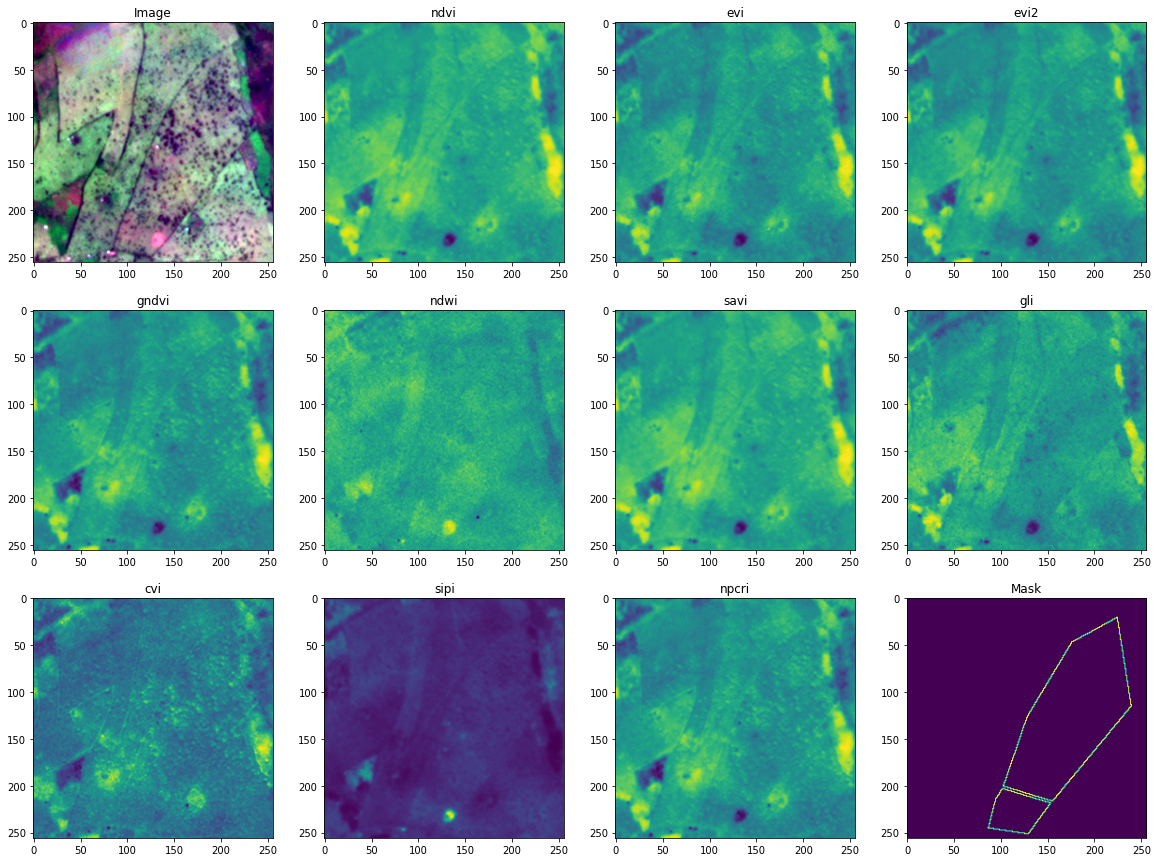

In [10]:
dataset = ExploreSet()

Mean = np.array([0.049, 0.083, 0.088, 0.303])
Std = np.array([0.0134, 0.0135, 0.02, 0.0516])
NORM = 10000 #65535


IDX = 19

imgs,mask = dataset.__getitem__(IDX,totensor=False,only_imgs=False)
print(mask.shape)
imgs = np.stack(imgs,axis=0).astype(np.float32)

names = all_names
add_indexes = get_additional_indexes(imgs,names)

#print(imgs.shape)

n_plots = 2 + len(names) 

n_cols = 4
n_rows = math.ceil(n_plots / n_cols)

fig,axs = plt.subplots(n_rows,n_cols,figsize=(n_cols*5,n_rows*5))

i = 1
img = imgs[i,...]

img = img.transpose(1,2,0)
img = normalize(img,Mean,Std,NORM)
img = img #*5
img = (img + 1)/ 2
rgb = img[:,:,[2,1,0]]

axs[0,0].imshow(rgb)
axs[0,0].set_title('Image')

for j,arr in enumerate(add_indexes):
    row,col = (j+1) // n_cols, (j+1) % (n_cols)
    arr = arr[i,0,...]
    
    if names[j] == 'evi':
        print(np.unique(arr))
    arr = arr/arr.max()
    axs[row,col].imshow(arr)
    axs[row,col].set_title(names[j])

row,col = (j+2) // n_cols, (j+2) % (n_cols)
axs[row,col].imshow(mask[0])
axs[row,col].set_title('Mask')


In [15]:
all_names = ['ndvi','evi','evi2','gndvi','ndwi','savi','gli','cvi','sipi','npcri']

tsize = 256
tarea = tsize ** 2
#NORM_IDX = 10000

dataset = ExploreSet()
#loader = DataLoader(dataset=dataset,batch_size=bs,num_workers=2,pin_memory=True)

#loader = tqdm(loader)
names = all_names
psum  = None
psum_sq = None

count = 0

max = None

for idx in range(len(dataset)):
    imgs = dataset.__getitem__(idx,totensor=False,only_imgs=True)
    imgs = np.stack(imgs,axis=0).astype(np.float32)
    
    add_indexes = get_additional_indexes(imgs,names)
    add_indexes = np.concatenate(add_indexes,axis=1).astype(np.float32)
    #add_indexes /= NORM_IDX 

    x = torch.from_numpy(add_indexes).cuda()
    T,C,H,W = x.shape

    psum_now = x.sum(axis=[0, 2, 3]).unsqueeze(0)
    psum_sq_now = (x ** 2).sum(axis=[0, 2, 3]).unsqueeze(0)

    if psum is None:
        psum = psum_now
        psum_sq = psum_sq_now
    else:
        psum = torch.cat([psum,psum_now],dim=0)
        psum_sq = torch.cat([psum_sq,psum_sq_now],dim=0)

    count += T

    x = x.view(T,C,-1)
    x = x.permute(1,0,-1)
    x = x.reshape(C,-1)
    max_now ,_= x.max(dim=1) 
    #print(max_now)
    if max is None:
        max = max_now
    else:
        max,_ = torch.cat([max,max_now]).view(2,C).max(dim=0)




count *= tarea
total_mean = (psum  / count).sum(dim=0) 
total_var = (psum_sq / count).sum(dim=0)  - ((total_mean ) ** 2)
total_std  = torch.sqrt(total_var)


#max_now *= NORM_IDX
print(max_now)
print(total_mean)
print(total_var)
print(total_std)

mean_dict = {}
std_dict = {}

for k,name in enumerate(names):

    mean_dict[name] = total_mean[k].item()
    std_dict[name] = total_std[k].item()

/home/hasann/anaconda3/envs/pytorch_venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


tensor([ 0.8232,  2.3079,  1.8309,  0.7365,  0.4125,  1.2345,  0.3090,  6.7038,
         3.0641, -0.2079], device='cuda:0')
tensor([ 0.5442,  1.1672,  1.0451,  0.5653,  0.2906,  0.8162,  0.1024,  3.8554,
         1.2130, -0.5653], device='cuda:0')
tensor([1.0880e-02, 5.5621e+00, 6.2458e-02, 4.4281e-03, 3.7208e-03, 2.4472e-02,
        2.6879e-03, 2.7819e-01, 2.1128e-01, 4.4281e-03], device='cuda:0')
tensor([0.1043, 2.3584, 0.2499, 0.0665, 0.0610, 0.1564, 0.0518, 0.5274, 0.4597,
        0.0665], device='cuda:0')


In [16]:
print(mean_dict)
print(std_dict)

{'ndvi': 0.5442473888397217, 'evi': 1.1672191619873047, 'evi2': 1.0451245307922363, 'gndvi': 0.5653371810913086, 'ndwi': 0.29057252407073975, 'savi': 0.8161605596542358, 'gli': 0.1024172306060791, 'cvi': 3.855412006378174, 'sipi': 1.2129534482955933, 'npcri': -0.5653371810913086}
{'ndvi': 0.10430891811847687, 'evi': 2.358415126800537, 'evi2': 0.24991534650325775, 'gndvi': 0.06654366105794907, 'ndwi': 0.060998644679784775, 'savi': 0.15643471479415894, 'gli': 0.051844559609889984, 'cvi': 0.5274387001991272, 'sipi': 0.4596547484397888, 'npcri': 0.06654366105794907}


In [4]:
bs=1

tsize = 256
tarea = tsize ** 2
NORM = 10000

dataset = ExploreSet()
loader = DataLoader(dataset=dataset,batch_size=bs,num_workers=2,pin_memory=True)

loader = tqdm(loader)

psum  = None
psum_sq = None

count = 0
for x in loader:
    #print(x.shape)
    #x = x.cuda()
    B,T,C,H,W = x.shape
    x = x.view(B*T,C,H,W)

    #print(x.shape)
    
    x = x / NORM

    psum_now = x.sum(axis=[0, 2, 3]).unsqueeze(0)
    psum_sq_now = (x ** 2).sum(axis=[0, 2, 3]).unsqueeze(0)

    if psum is None:
        psum = psum_now
        psum_sq = psum_sq_now
    else:
        psum = torch.cat([psum,psum_now],dim=0)
        psum_sq = torch.cat([psum_sq,psum_sq_now],dim=0)

    count += (B*T)

count *= tarea
total_mean = (psum / count).sum(dim=0)
total_var = (psum_sq / count).sum(dim=0) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

  0%|          | 0/70 [00:00<?, ?it/s]

In [16]:

dataset = ExploreSet()
loader = DataLoader(dataset=dataset,batch_size=70,num_workers=2,pin_memory=True)
data = next(iter(loader))
B,T,C,H,W = data.shape
data = data.view(B*T,C,H,W) / NORM
#data = data.view(B*T,C,-1)
mean = data.numpy().mean(axis=(0,2,3))
std = data.numpy().std(axis=(0,2,3))
mean2 = data.numpy().mean(axis=(2,3)).mean(axis=0)
std2 = data.numpy().std(axis=(2,3)).mean(axis=0)
print(mean)
print(std)
print(mean2)
print(std2)

[0.04842762 0.0829068  0.08804967 0.30294216]
[0.01341773 0.0134506  0.02016291 0.05160911]
[0.04842762 0.08290687 0.08804976 0.302942  ]
[0.00613706 0.00790184 0.01250899 0.03852398]


In [134]:
max = None
for x in loader:

    B,T,C,H,W = x.shape
    x = x.view(B*T,C,-1)
    x = x.permute(1,0,-1)
    x = x.reshape(C,-1)
    #print(x.shape)
    #print(x.max(dim=1))
    max_now ,_= x.max(dim=1)
    print(max_now)
    if max is None:
        max = max_now
    else:
        max,_ = torch.cat([max,max_now]).view(2,C).max(dim=0)
        print(max)


tensor([4088., 4003., 6067., 5363.])
tensor([4795., 5627., 8814., 9989.])
tensor([4795., 5627., 8814., 9989.])
tensor([4251., 4589., 6381., 7041.])
tensor([4795., 5627., 8814., 9989.])
tensor([2499., 3400., 3602., 5373.])
tensor([4795., 5627., 8814., 9989.])
tensor([3370., 3773., 4159., 5706.])
tensor([4795., 5627., 8814., 9989.])
tensor([2346., 2534., 2904., 6340.])
tensor([4795., 5627., 8814., 9989.])
tensor([1867., 2713., 2646., 6512.])
tensor([4795., 5627., 8814., 9989.])
tensor([4064., 5064., 7818., 6710.])
tensor([4795., 5627., 8814., 9989.])
tensor([3299., 2363., 2900., 5297.])
tensor([4795., 5627., 8814., 9989.])
tensor([1811., 2185., 2405., 5157.])
tensor([4795., 5627., 8814., 9989.])
tensor([2632., 2656., 3186., 4893.])
tensor([4795., 5627., 8814., 9989.])
tensor([2213., 3009., 3031., 5240.])
tensor([4795., 5627., 8814., 9989.])
tensor([1633., 2249., 2561., 5316.])
tensor([4795., 5627., 8814., 9989.])
tensor([2034., 2619., 2530., 5375.])
tensor([4795., 5627., 8814., 9989.])
t

In [5]:
print('Mean:',np.around(total_mean.cpu().numpy(),decimals=5).tolist())
print('Std:' , np.around(total_std.cpu().numpy(),decimals=5).tolist())

Mean: [0.04842999950051308, 0.08291000127792358, 0.0880500003695488, 0.3029400110244751]
Std: [0.013419999741017818, 0.013450000435113907, 0.020160000771284103, 0.05161000043153763]
